# Health determinants across countries

In [1]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

plt.style.use("classic")

import pandas as pd
import numpy as np

from scipy import stats

import requests
from html.parser import HTMLParser
from IPython.display import HTML

In [2]:
filename = "data/data.xls"

def read_data(filename=filename):
    data = pd.read_excel(filename)
    return data


data = read_data()
data.head()

,country,height,weight,sex,age,degree,exercise,drinking,smoking
0,276,183,99,1,25,4,1,2,2
1,752,172,80,1,46,2,2,2,2
2,752,187,86,1,18,3,1,2,2
3,752,187,117,1,54,5,2,2,2
4,752,174,73,1,33,3,2,2,2


In [3]:
print('Количество людей всего - %i, в 276-стране - %i, в 752-стране - %i' % 
      (data.shape[0], data[data.country == 276].shape[0], data[data.country == 752].shape[0]))

Количество людей всего - 258, в 276-стране - 76, в 752-стране - 182


# 1. Data preparation:

## 1.1

**I.** `2` записи с мусорным значением `9` в столбце `smoking`.

In [4]:
data.smoking.value_counts()

2    214
1     42
9      2
Name: smoking, dtype: int64

**II.** Нет мусорных значений в столбце `drinking`.

In [5]:
data.drinking.value_counts()

2    242
1     16
Name: drinking, dtype: int64

**III.** `9` записей с мусорным значением `9` в столбце `exercise`.

In [6]:
data.exercise.value_counts()

1    136
2    113
9      9
Name: exercise, dtype: int64

**IV.** Не совсем понятно, что значит столбец `degree`, но будем считать, что он может принимать значения от `0` до `6` включительно, и в наших данных присутствует `3` записи с мусорным значением `9`.

In [7]:
data.degree.value_counts()

4    54
2    54
3    46
6    45
5    33
1    21
9     3
0     2
Name: degree, dtype: int64

**V.** Максимальный зафиксированный возраст человека - `160` лет. Поэтому можно считать, что в колонке `age` все значение валидные.

[Max Human Lifespan](https://en.wikipedia.org/wiki/Maximum_life_span)

In [8]:
data.age[data.age >= 160].value_counts()

Series([], Name: age, dtype: int64)

**VI.** В колонке `sex` нет мусорных значений.

In [9]:
data.sex.value_counts()

1    132
2    126
Name: sex, dtype: int64

**VII.** Максимальный зафиксированный вес человека - `635` килограмм, поэтому в наших данных есть `9` записей с мусорным значением `999` и `1` - с `998`.

[Max Human Weight](https://en.wikipedia.org/wiki/Jon_Brower_Minnoch)

In [10]:
data.weight[data.weight >= 635].value_counts()

999    9
998    1
Name: weight, dtype: int64

**VIII.** Максимальный зафиксированный рост человека - `272` сантиметра, поэтому в наших данных `2` записи с мусорным значением `999`.

In [11]:
data.height[data.height >= 272].value_counts()

999    2
Name: height, dtype: int64

На рисунке видно, что у нас незначительное количество записей с мусорными данными. Давайте их отфельтруем.

In [176]:
from typing import Dict, Sequence, Tuple, Any, Optional
from dataclasses import dataclass, field
from functools import lru_cache


NO_ARGS_OPTION = "NO_ARGS_OPTION"


@dataclass
class ChartData:
    ptype: str
    x: Sequence[Any]
    y: Sequence[Any]
    args: Tuple[Any] = field(default_factory=tuple)
    kwargs: Dict[str, Any] = field(default_factory=dict)
    options: Dict[str, Any] = field(default_factory=dict)

    def __iter__(self):
        return iter((self.ptype, self.x, self.y, self.args, self.kwargs, self.options))


class ChartCreator:
    _instance = None
    
    def __new__(cls):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
        return cls._instance

    def _preprocess(self, figsize):
        plt.figure(figsize=figsize)

    def _postprocess(self):
        pass
    
    def _draw_chart_data(self, ptype, x, y, args, kwargs, options):
        pfunc = getattr(plt, ptype, None)

        assert pfunc is not None, "Unknown type of chart"

        pfunc(x, y, *args, **kwargs)

        for option, value in options.items():
            ofunc = getattr(plt, option, None)

            assert ofunc is not None, "Unknown option for chart"

            if value is not NO_ARGS_OPTION:
                ofunc(value)
            else:
                ofunc()
    
    @lru_cache(maxsize=16)
    def _get_optimal_axes_shape(self, number):
        if number == 2:
            return 1, 2
        elif number == 3:
            return 1, 3
        elif number % 2 == 0:
            return number // 2, 2
        elif number % 3 == 0:
            return number // 3, 3
        else:
            return number, 1
    
    def _add_axes(self, idx, number):
        plt.subplot(*self._get_optimal_axes_shape(number), idx)
            
    def draw(self, *chart_datas, figsize=(15, 10), separate_axes=False):
        self._preprocess(figsize)

        for idx, (ptype, x, y, args, kwargs, options) in enumerate(chart_datas, 1):
            if separate_axes:
                self._add_axes(idx, len(chart_datas))
            self._draw_chart_data(ptype, x, y, args, kwargs, options)

        self._postprocess()

chart_creator = ChartCreator()

In [152]:
def curve_smoothing(df, key_name, value_name, N=1):
    df = df[[key_name, value_name]]
    
    lines = [df]
    for i in range(1, N + 1):
        line = df[value_name].copy()
        line[N:] = line[:-N]
        lines.append(line)
    for i in range(1, N + 1):
        line = df[value_name].copy()
        line[:-N] = line[N:]
        lines.append(line)

    df = pd.concat(lines, axis=1, ignore_index=True)
    df[value_name] = np.mean(df[[i for i in range(1, 2 * N + 2)]], axis=1)
    df = df[[0, value_name]]
    df.columns = [key_name, value_name]
    return df

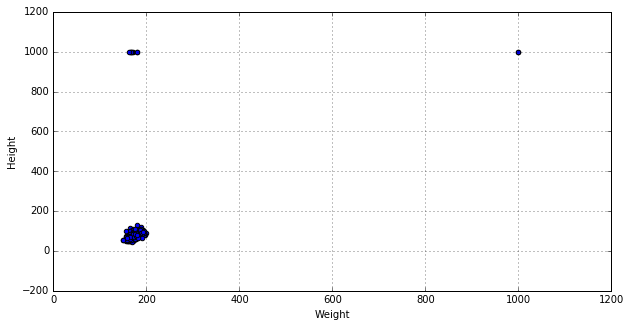

In [156]:
chart_data = ChartData(ptype="scatter", 
                       x=data.height, 
                       y=data.weight, 
                       options=dict(xlabel="Weight", ylabel="Height", grid=True))
chart_creator.draw(chart_data, figsize=(10, 5))

## 1.2

In [130]:
filter_data = data[(data.smoking != 9) & 
                   (data.exercise != 9) & 
                   (data.degree != 9) & 
                   (data.weight != 999) & (data.weight != 998) & 
                   (data.height != 999)]

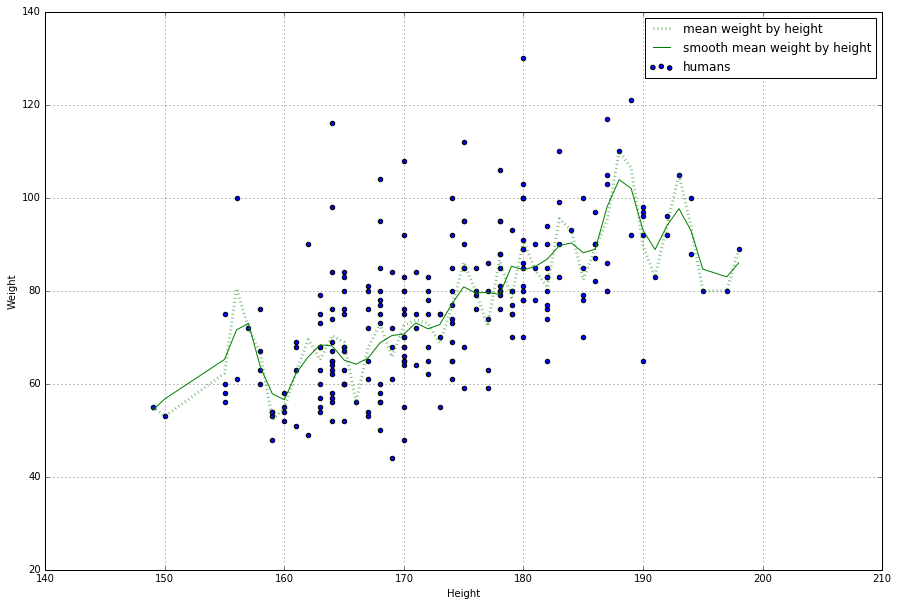

In [157]:
mean_weight = filter_data[["height", "weight"]].groupby(by="height").mean().reset_index()
smooth_mean_weigh = curve_smoothing(mean_weight, "height", "weight", N=1)

chart_creator.draw(
    ChartData(ptype="scatter",
              x=filter_data.height,
              y=filter_data.weight,
              kwargs=dict(label="humans")),
    ChartData(ptype="plot",
              x=mean_weight.height,
              y=mean_weight.weight,
              args=("g:",),
              kwargs=dict(label="mean weight by height", alpha=0.5, linewidth=3)),
    ChartData(ptype="plot",
              x=smooth_mean_weigh.height,
              y=smooth_mean_weigh.weight,
              args=("g",),
              kwargs=dict(label="smooth mean weight by height"),
              options=dict(xlabel="Height", ylabel="Weight", legend=NO_ARGS_OPTION, grid=True))
)

1. По рисунку видно, что явно разделяются мужчины и женщины относительно роста и веса.
1. Также курящие люди в нашей выборке оказались меньше ростом и весом.
1. А у пьющих - большой вес, хотя таких людей всего `16` из `258`.

Далее более детально посмотрим на столбцы `sex`, `age`, `degree` и `exercise`.

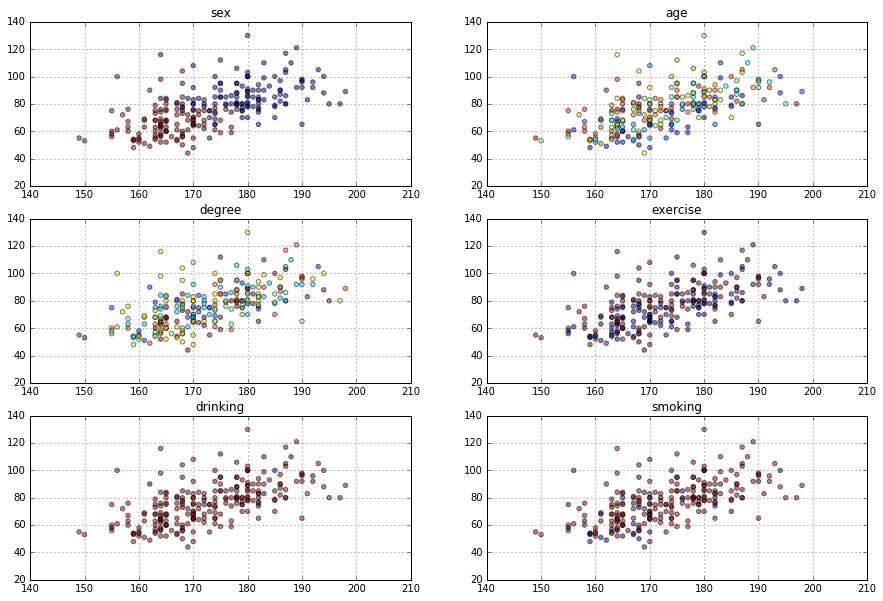

In [177]:
chart_creator.draw(
    *(ChartData(ptype="scatter",
                x=filter_data.height,
                y=filter_data.weight,
                kwargs=dict(c=filter_data[field], alpha=0.5),
                options=dict(title=field, grid=True))
      for field in filter_data.columns[3:]),
    separate_axes=True
)

### sex

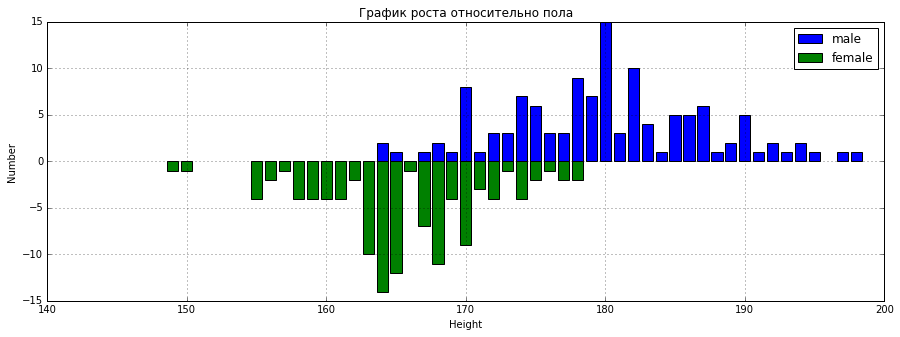

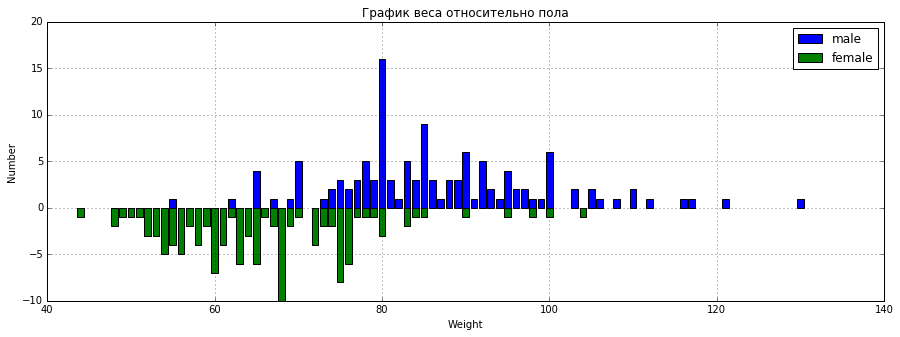

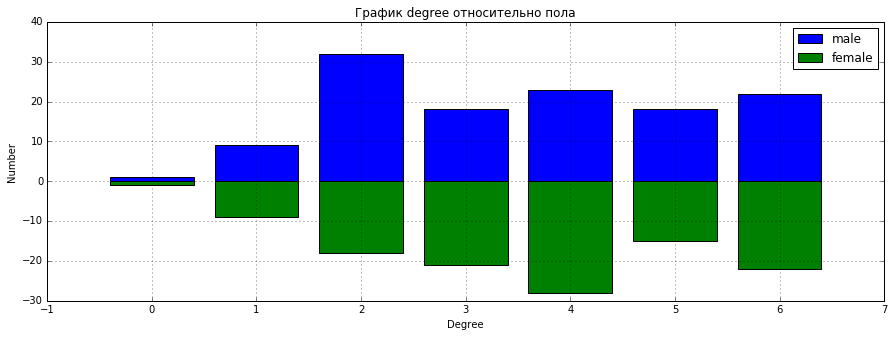

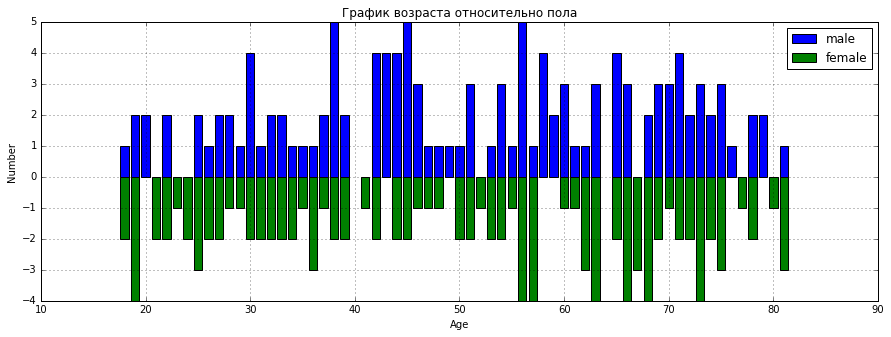

In [186]:
chart_creator.draw(
    ChartData(ptype="bar",
              x=np.sort(filter_data.height[filter_data.sex == 1].unique()),
              y=filter_data[["height", "sex"]][filter_data.sex == 1].groupby("height").count().sex,
              kwargs=dict(label="male")),
    ChartData(ptype="bar",
              x=np.sort(filter_data.height[filter_data.sex == 2].unique()),
              y=-filter_data[["height", "sex"]][filter_data.sex == 2].groupby("height").count().sex,
              kwargs=dict(label="female"),
              options=dict(grid=True, xlabel="Height", ylabel="Number", legend=NO_ARGS_OPTION, 
                           title="График роста относительно пола")),
    figsize=(15, 5)
)

chart_creator.draw(
    ChartData(ptype="bar",
              x=np.sort(filter_data.weight[filter_data.sex == 1].unique()),
              y=filter_data[["weight", "sex"]][filter_data.sex == 1].groupby("weight").count().sex,
              kwargs=dict(label="male")),
    ChartData(ptype="bar",
              x=np.sort(filter_data.weight[filter_data.sex == 2].unique()),
              y=-filter_data[["weight", "sex"]][filter_data.sex == 2].groupby("weight").count().sex,
              kwargs=dict(label="female"),
              options=dict(grid=True, xlabel="Weight", ylabel="Number", legend=NO_ARGS_OPTION, 
                           title="График веса относительно пола")),
    figsize=(15, 5)
)

chart_creator.draw(
    ChartData(ptype="bar",
              x=np.sort(filter_data.degree[filter_data.sex == 1].unique()),
              y=filter_data[["degree", "sex"]][filter_data.sex == 1].groupby("degree").count().sex,
              kwargs=dict(label="male")),
    ChartData(ptype="bar",
              x=np.sort(filter_data.degree[filter_data.sex == 2].unique()),
              y=-filter_data[["degree", "sex"]][filter_data.sex == 2].groupby("degree").count().sex,
              kwargs=dict(label="female"),
              options=dict(grid=True, xlabel="Degree", ylabel="Number", legend=NO_ARGS_OPTION, 
                           title="График degree относительно пола")),
    figsize=(15, 5)
)

chart_creator.draw(
    ChartData(ptype="bar",
              x=np.sort(filter_data.age[filter_data.sex == 1].unique()),
              y=filter_data[["age", "sex"]][filter_data.sex == 1].groupby("age").count().sex,
              kwargs=dict(label="male")),
    ChartData(ptype="bar",
              x=np.sort(filter_data.age[filter_data.sex == 2].unique()),
              y=-filter_data[["age", "sex"]][filter_data.sex == 2].groupby("age").count().sex,
              kwargs=dict(label="female"),
              options=dict(grid=True, xlabel="Age", ylabel="Number", legend=NO_ARGS_OPTION, 
                           title="График возраста относительно пола")),
    figsize=(15, 5)
)

### age

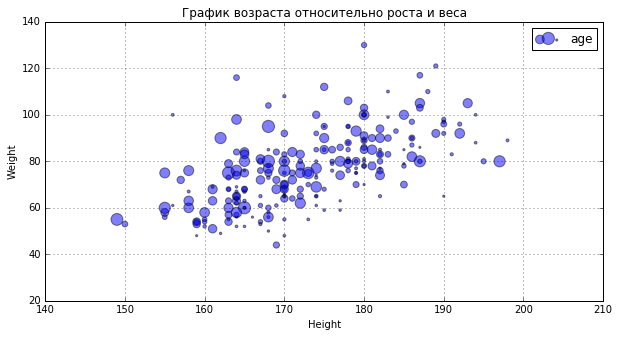

In [165]:
plt.figure(figsize=(10, 5))

plt.scatter(filter_data.height, 
            filter_data.weight, 
#             c=(filter_data.age - filter_data.age.mean()).apply(lambda x: 1 if x > 0 else 2), 
            s=np.exp(filter_data.age / filter_data.age.min() + 0.5),
            alpha=0.5,
            label="age"
)
plt.ylabel("Weight")
plt.xlabel("Height")
plt.grid()
plt.title("График возраста относительно роста и веса")
plt.legend()


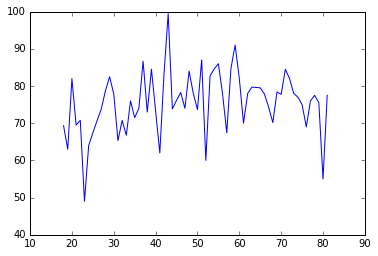

In [187]:
weight_by_ages = filter_data[["age", "weight"]].sort_values("age").groupby("age").mean().reset_index()

plt.plot(weight_by_ages.age, weight_by_ages.weight)

# TODO: добавить сглаживание (вынести в отдельные функции)
# TODO: всё отрефакторить

(array([[ 1.,  0.,  1., 16.,  7., 10.],
        [ 0.,  0.,  3., 10.,  7., 18.],
        [ 0.,  0.,  9.,  5.,  8., 15.],
        [ 1.,  0.,  8.,  1., 12., 17.],
        [ 0.,  8., 19.,  7.,  7.,  7.],
        [ 0., 10., 10.,  0., 10., 10.]]),
 array([18. , 28.5, 39. , 49.5, 60. , 70.5, 81. ]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 <matplotlib.collections.QuadMesh at 0x7fc5c11ab6d8>)

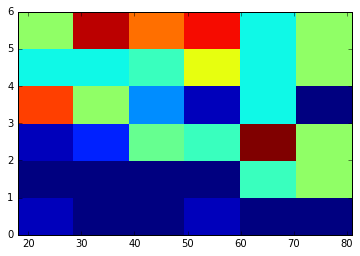

In [188]:
plt.hist2d(filter_data.age, filter_data.degree, bins=6)

### degree

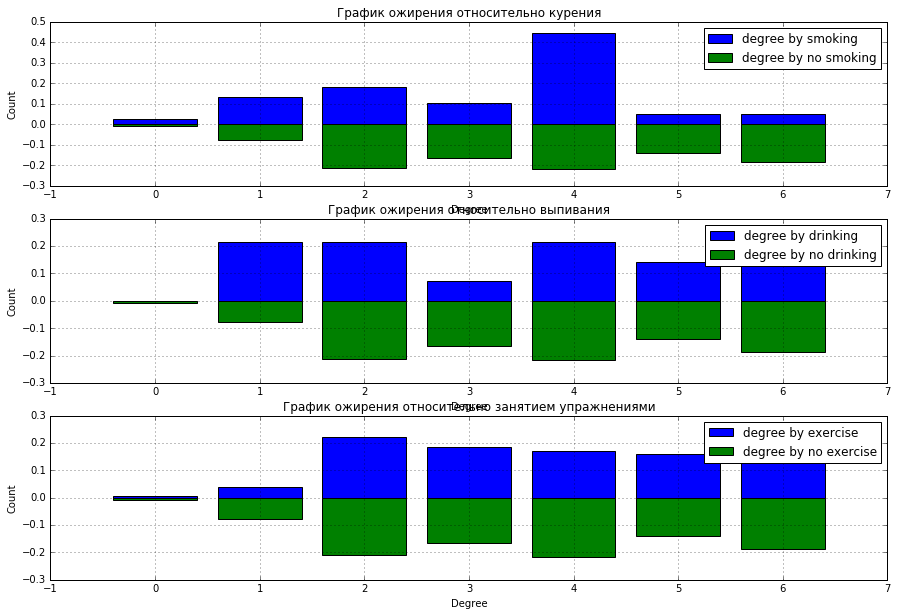

In [166]:
def normalize(series):
    return series / series.sum()


plt.figure(figsize=(15, 10))

plt.subplot(311)
plt.bar(
    np.sort(filter_data[filter_data.smoking == 1].degree.unique()), 
    normalize(filter_data[["degree", "smoking"]][filter_data.smoking == 1].groupby("degree").count().smoking),
    label="degree by smoking"
)
plt.bar(
    np.sort(filter_data.degree.unique()), 
    -normalize(filter_data[["degree", "smoking"]].groupby("degree").count().smoking),
    label="degree by no smoking"
)
plt.ylabel("Count")
plt.xlabel("Degree")
plt.grid()
plt.title("График ожирения относительно курения")
plt.legend()

plt.subplot(312)
plt.bar(
    np.sort(filter_data.degree[filter_data.drinking == 1].unique()), 
    normalize(filter_data[["degree", "drinking"]][filter_data.drinking == 1].groupby("degree").count().drinking),
    label="degree by drinking"
)
plt.bar(
    np.sort(filter_data.degree.unique()), 
    -normalize(filter_data[["degree", "drinking"]].groupby("degree").count().drinking),
    label="degree by no drinking"
)
plt.ylabel("Count")
plt.xlabel("Degree")
plt.grid()
plt.title("График ожирения относительно выпивания")
plt.legend()

plt.subplot(313)
plt.bar(
    np.sort(filter_data.degree[filter_data.exercise == 1].unique()), 
    normalize(filter_data[["degree", "exercise"]][filter_data.exercise == 1].groupby("degree").count().exercise),
    label="degree by exercise"
)
plt.bar(
    np.sort(filter_data.degree.unique()), 
    -normalize(filter_data[["degree", "exercise"]].groupby("degree").count().exercise),
    label="degree by no exercise"
)
plt.ylabel("Count")
plt.xlabel("Degree")
plt.grid()
plt.title("График ожирения относительно занятием упражнениями")
plt.legend()

### exercise

In [202]:
# TODO добавить графики для sex, age, degree, exercise

### Дальше

height       AxesSubplot(0.125,0.125;0.168478x0.775)
weight    AxesSubplot(0.327174,0.125;0.168478x0.775)
age       AxesSubplot(0.529348,0.125;0.168478x0.775)
degree    AxesSubplot(0.731522,0.125;0.168478x0.775)
dtype: object

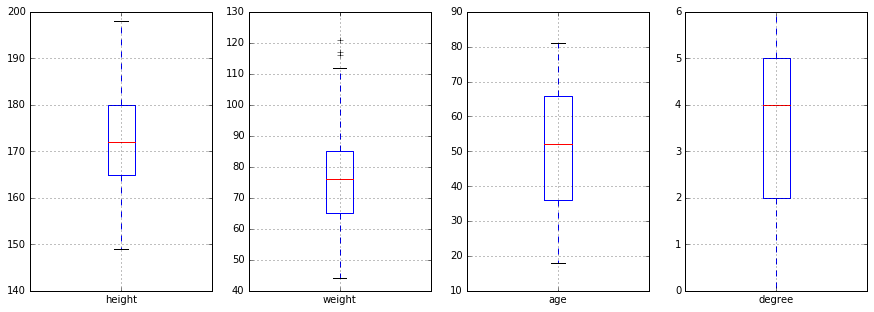

In [203]:
filter_data[['height', 'weight', 'age', 'degree']].plot(
    kind='box', subplots=True, figsize=(15, 5), sym='+', grid=True)

In [204]:
bad_row_count = data.shape[0] - filter_data.shape[0]
p = float(bad_row_count) / data.shape[0]

print('p=%f' % p)

p=0.081395


In [205]:
n = data.shape[0]
E = n * p
D = float(n) * (p - p * p)

print('E=%f, D=%f' % (E, D))

E=21.000000, D=19.290698


$95\%$ доверительный интервал: $(\overline{x} - 1.96 \cdot \sigma,\ \overline{x} + 1.96 + \cdot \sigma)$

## 1.3

Индекс массы тела рассчитывается по формуле:

$$I = \frac{m}{h^2},$$

где:
* $m$ - масса тела в килограммах
* $h$ - рост в метрах,

и измеряется в $kg/m^2$

In [196]:
final_data = filter_data.copy()
final_data.height = final_data.height / 100.
final_data['bmi'] = final_data.weight / (final_data.height * final_data.height)

final_data.head()

,country,height,weight,sex,age,degree,exercise,drinking,smoking,bmi
0,276,1.83,99,1,25,4,1,2,2,29.561946
1,752,1.72,80,1,46,2,2,2,2,27.041644
2,752,1.87,86,1,18,3,1,2,2,24.593211
3,752,1.87,117,1,54,5,2,2,2,33.458206
4,752,1.74,73,1,33,3,2,2,2,24.111507


Между столбцами `degree` и `bmi` нет никакой зависимости. Возможно, столбец `degree` содержит просто рандомные данные.

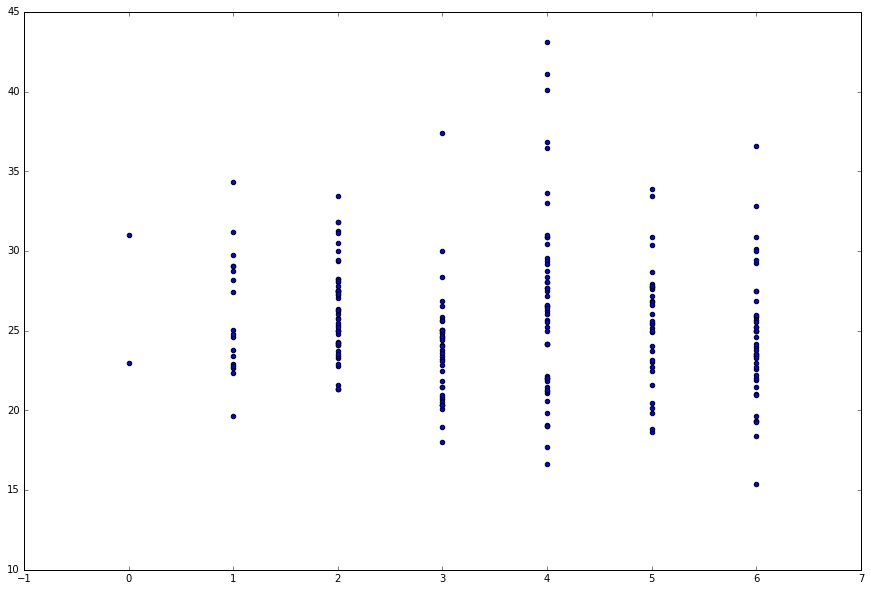

In [198]:
plt.figure(figsize=(15, 10))
plt.scatter(final_data.degree, final_data.bmi)

## Таблица BMI

In [199]:
class MyHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._is_my_table = False
        self._result = []

    def handle_starttag(self, tag, attrs):
        if tag == 'table' and ('class', 'standard') in attrs:
            self._is_my_table = True
        
        if self._is_my_table:
            self._result.append('<%s>' % tag)
    
    def handle_endtag(self, tag):
        if self._is_my_table:
            self._result.append('</%s>' % tag)

        if self._is_my_table and tag == 'table':
            self._is_my_table = False

    def handle_data(self, data):
        if self._is_my_table and data.strip():
            self._result.append(data)


url = "https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D0%B4%D0%B5%D0%BA%D1%81_" + \
        "%D0%BC%D0%B0%D1%81%D1%81%D1%8B_%D1%82%D0%B5%D0%BB%D0%B0"
response = requests.get(url)


parser = MyHTMLParser()

parser.feed(response.content.decode('utf-8'))
HTML(''.join(parser._result))

Индекс массы тела,Соответствие между массой человека и его ростом
16 и менее,Выраженный дефицит массы тела
"16—18,5",Недостаточная (дефицит) масса тела
"18,5—24,99",Норма
25—30,Избыточная масса тела (предожирение)
30—35,Ожирение
35—40,Ожирение резкое
40 и более,Очень резкое ожирение


## График BMI для наших данных

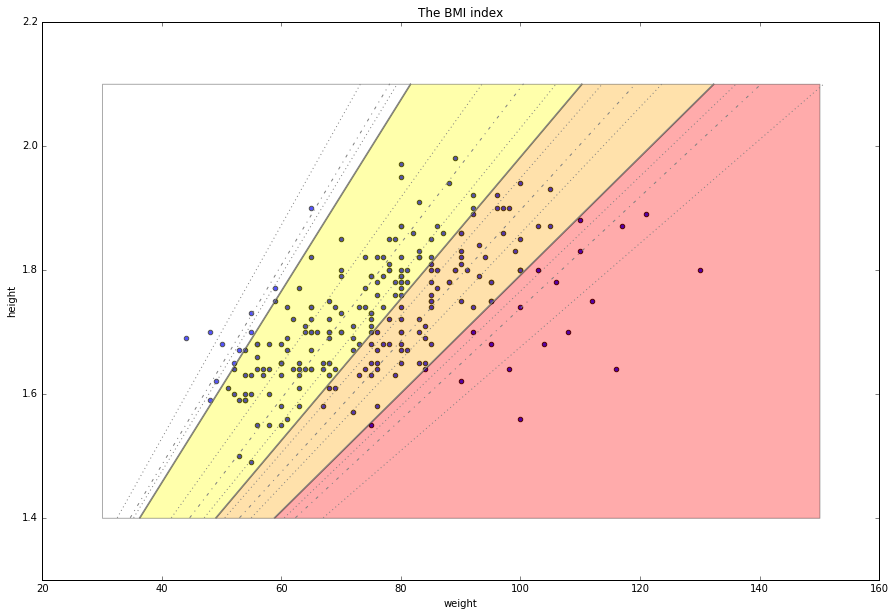

In [201]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

ax.scatter(final_data.weight, final_data.height)
ax.set_xlabel('weight')
ax.set_ylabel('height')

ax.set_title('The BMI index')

# x / y ** 2 == i
y = [1.4, 2.1]
x1 = [18.5 * 1.4 ** 2, 18.5 * 2.1 ** 2]
x2 = [25 * 1.4 ** 2, 25 * 2.1 ** 2]
x3 = [30 * 1.4 ** 2, 30 * 2.1 ** 2]

ax.plot(x1, y, c='grey')
ax.plot(x2, y, c='grey')
ax.plot(x3, y, c='grey')
ax.fill_betweenx(y, 30, x1, facecolor='white', alpha=0.33)
ax.fill_betweenx(y, x1, x2, facecolor='yellow', alpha=0.33)
ax.fill_betweenx(y, x2, x3, facecolor='orange', alpha=0.33)
ax.fill_betweenx(y, x3, 150, facecolor='red', alpha=0.33)

bmi = np.percentile(final_data[final_data.bmi < 18.5].bmi, 50)
mean_x = [bmi * 1.4 ** 2, bmi * 2.1 ** 2]
ax.plot(mean_x, y, c='grey', ls='-.')
bmi = np.percentile(final_data[final_data.bmi < 18.5].bmi, 25)
mean_x = [bmi * 1.4 ** 2, bmi * 2.1 ** 2]
ax.plot(mean_x, y, c='grey', ls=':')
bmi = np.percentile(final_data[final_data.bmi < 18.5].bmi, 75)
mean_x = [bmi * 1.4 ** 2, bmi * 2.1 ** 2]
ax.plot(mean_x, y, c='grey', ls=':')

bmi = np.percentile(final_data[(final_data.bmi >= 18.5) & (final_data.bmi < 25)].bmi, 50)
mean_x = [bmi * 1.4 ** 2, bmi * 2.1 ** 2]
ax.plot(mean_x, y, c='grey', ls='-.')
bmi = np.percentile(final_data[(final_data.bmi >= 18.5) & (final_data.bmi < 25)].bmi, 25)
mean_x = [bmi * 1.4 ** 2, bmi * 2.1 ** 2]
ax.plot(mean_x, y, c='grey', ls=':')
bmi = np.percentile(final_data[(final_data.bmi >= 18.5) & (final_data.bmi < 25)].bmi, 75)
mean_x = [bmi * 1.4 ** 2, bmi * 2.1 ** 2]
ax.plot(mean_x, y, c='grey', ls=':')

bmi = np.percentile(final_data[(final_data.bmi >= 25) & (final_data.bmi < 30)].bmi, 50)
mean_x = [bmi * 1.4 ** 2, bmi * 2.1 ** 2]
ax.plot(mean_x, y, c='grey', ls='-.')
bmi = np.percentile(final_data[(final_data.bmi >= 25) & (final_data.bmi < 30)].bmi, 25)
mean_x = [bmi * 1.4 ** 2, bmi * 2.1 ** 2]
ax.plot(mean_x, y, c='grey', ls=':')
bmi = np.percentile(final_data[(final_data.bmi >= 25) & (final_data.bmi < 30)].bmi, 75)
mean_x = [bmi * 1.4 ** 2, bmi * 2.1 ** 2]
ax.plot(mean_x, y, c='grey', ls=':')

bmi = np.percentile(final_data[final_data.bmi >= 30].bmi, 50)
mean_x = [bmi * 1.4 ** 2, bmi * 2.1 ** 2]
ax.plot(mean_x, y, c='grey', ls='-.')
bmi = np.percentile(final_data[final_data.bmi >= 30].bmi, 25)
mean_x = [bmi * 1.4 ** 2, bmi * 2.1 ** 2]
ax.plot(mean_x, y, c='grey', ls=':')
bmi = np.percentile(final_data[final_data.bmi >= 30].bmi, 75)
mean_x = [bmi * 1.4 ** 2, bmi * 2.1 ** 2]
ax.plot(mean_x, y, c='grey', ls=':')

# 2. Initial comparisons:

## 2.1

### Математическое ожидание

In [207]:
final_data.groupby('country').bmi.mean()

country
276    26.484261
752    25.055587
Name: bmi, dtype: float64

### Среднеквадратическое отклонение

In [208]:
final_data.groupby('country').bmi.std()

country
276    5.369079
752    3.610866
Name: bmi, dtype: float64

### Skewness

In [209]:
final_data.groupby('country').bmi.skew()

country
276    0.895722
752    0.407655
Name: bmi, dtype: float64

### 25%, 50%, 75% квантили

In [210]:
final_data.groupby('country').bmi.quantile([0.25, 0.5, 0.75])

country      
276      0.25    22.204082
         0.50    26.041667
         0.75    29.210110
752      0.25    22.825617
         0.50    24.962303
         0.75    27.443101
Name: bmi, dtype: float64

Text(0.5, 1.0, '752')

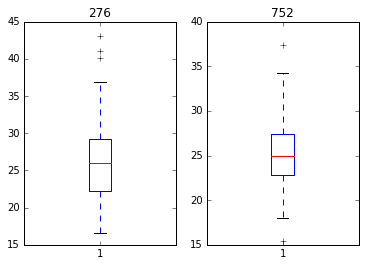

In [212]:
_, (ax1, ax2) = plt.subplots(1, 2)

ax1.boxplot(final_data[final_data.country == 276].bmi.values)
ax1.set_title('276')
ax2.boxplot(final_data[final_data.country == 752].bmi.values)
ax2.set_title('752')

### Зависимость между ростом и весом

country
276    AxesSubplot(0.125,0.125;0.775x0.775)
752    AxesSubplot(0.125,0.125;0.775x0.775)
dtype: object

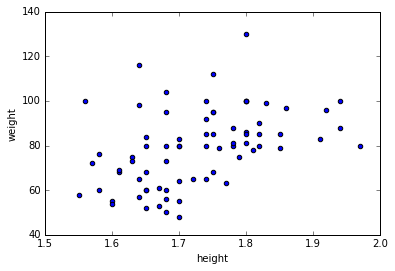

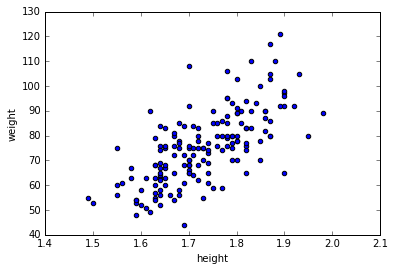

In [214]:
final_data.groupby('country').plot(x='height', y='weight', kind='scatter')

In [215]:
final_data.groupby('country')[['height', 'weight']].corr('pearson')

height    weight
country                           
276     height  1.000000  0.439255
        weight  0.439255  1.000000
752     height  1.000000  0.692151
        weight  0.692151  1.000000

### Зависимость между ростом и bmi

country
276    AxesSubplot(0.125,0.125;0.775x0.775)
752    AxesSubplot(0.125,0.125;0.775x0.775)
dtype: object

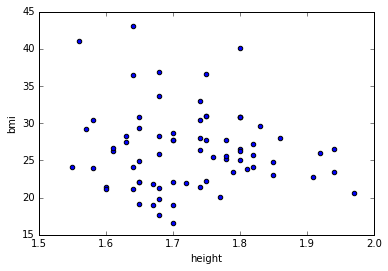

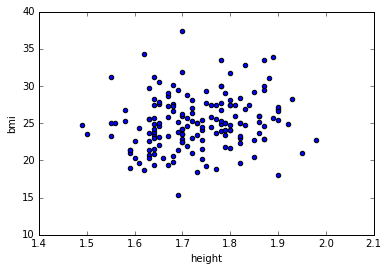

In [217]:
final_data.groupby('country').plot(x='height', y='bmi', kind='scatter')

In [216]:
final_data.groupby('country')[['height', 'bmi']].corr('pearson')

height       bmi
country                           
276     height  1.000000 -0.075848
        bmi    -0.075848  1.000000
752     height  1.000000  0.166017
        bmi     0.166017  1.000000

## 2.2

In [222]:
final_data.groupby('country').bmi.mean()

country
276    26.484261
752    25.055587
Name: bmi, dtype: float64

In [221]:
final_data.bmi.mean()

25.495642369560855

## 2.3

# 3. Risk factors:

## a.     
*Нулевая гипотеза:* мужчины жирнее женщин.

*Алтернативная гипотеза:* женщины не менее жирные чем мужчин.

In [ ]:
men_data = (filter_data[filter_data.sex == 1].bmi > 25).astype(np.float32)
women_data = (filter_data[filter_data.sex == 2].bmi > 25).astype(np.float32)

In [ ]:
stats.f_oneway(men_data, women_data)

# 4. Conclusions